In [197]:
#Load required libraries

import scipy.integrate as spi     #integrater
from scipy.integrate import ode   #ode solver
from scipy.integrate import odeint
import scipy.stats as sps
import numpy as np                #a bunch fo math 
import matplotlib.pyplot as plt    #plotting package
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import seaborn                    #I just like the colors and style of Seaborn. it changes the defaults for 
seaborn.set_style('ticks')        #matplotlib
seaborn.set_color_codes()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) #set font for figures
rc('text', usetex=True)   #allow use of tex in figure captions, etc.


#### Age-structured SIR models ####

The most simplistic SIR equations for an immunizing disease describe the change in the number (or proportion) of individuals in each of three classes: susceptible, immune, and recovered. They are

\begin{align}
\frac{dS}{dt} &= -\beta I S \\
\frac{dI}{dt} &= \beta I S - \gamma I \\
\frac{dR}{dt} &= \gamma I.
\end{align}

Here, $\gamma$ is the recovery rate, which is the inverse of the average length of infectiousness, and $\beta$ gives the probability of an interaction between a susceptible and an infected individual resulting in a new infection. (Without birth or death incorporated into the model, these equations are of course subject to the constrant that $d/dt (S + I + R) =0$).

As a first step, we'll numerically generate the solution to these equations.

In [198]:
# The SIR model differential equations.
def derivSIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [199]:
#Define disease parameters. Ro is the average number of new cases an infected individual will
#generate. A good number to use for measles is 16. gamma is the inverse of the recovery rate - i.e., it is the
#average recovery time. beta is the probability that an interaction between susceptible and infected individuals will 
#lead to infection, and is defined via beta/gamma = Ro

Ro = 16.
gamma = 26. #1/(2 weeks) converted to year^-1
beta = Ro*gamma

#Set up time points for integration (in years, since this is how we defined gamma)
t_start = 0.
t_end = 0.5 #six months
dt = 0.0025
time = np.arange(t_start,t_end+dt,dt)

In [200]:
# Total population, N. (1, since we're going to evolve the proportions instead of the raw numbers.)
N = 1.
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

In [201]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, time, args=(N, beta, gamma))
S, I, R = ret.T

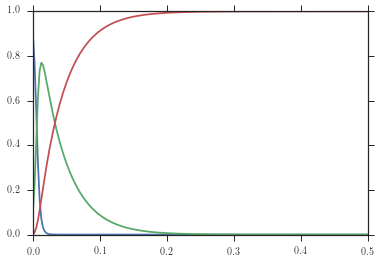

In [202]:
plt.plot(time,S)
plt.plot(time,I)
plt.plot(time,R)

The above figure shows susceptible (blue), infected (green), and recovered (red) proportions for a fast-moving epidemic. This model inherently assumes that all people interact with the same probability, regardless of age, location, or anything else. That's not a great model for actual human interaction, so we can add things to the model to make it a bit more realistic. 

I'll show you how we add age to the model because I've got the code handy in Python, and the concept is basically identical to how we add location: you split people into gropus, then have those groups interact with some probability. This changes the S, I, and R variables from scalars to vectors, and beta from a scalar to a matrix, where each element of the matrix represents the 'beta value' for the interaction between two age classes.

In [213]:
nage = 4             #Number of age classes
bins = np.ones(nage) #Bins all set to same width.
bins *= 10.

gamma = np.ones(nage) #gamma is a vector now.
gamma *= 26.          # 1./(2 weeks), converted to years.



In [277]:
#We have to define the derivative function in such a way that it can handle vectors and matrices:

def derivAS(y, t, N, beta, gamma):
    S = y[0:nage]
    I = y[nage:2*nage]
    R = y[2*nage:]
    
    dSdt = -np.multiply(np.dot(beta,I),S)      #dS/dt is -beta*S*I
    dIdt = np.multiply(np.dot(beta,I),S)  - np.multiply(gamma,I)
    dRdt = np.multiply(gamma,I)
    
    return np.hstack([dSdt,dIdt,dRdt])

Ro: 1.9999999999999996


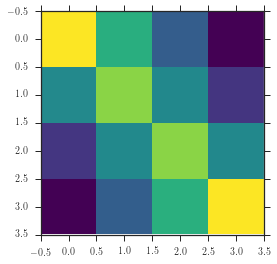

In [320]:
#Assortative mixing matrix - strong on the diagonals, weak on the off-diagonals. People mix most with their
#own age cohort.
beta = np.ones(nage)
beta = np.diag(beta)

for i in range(nage):  #There is probably a more efficient way to do this...
    for j in range(i,nage):
        beta[i,j] = 0.9**(j-i+1.)
        #if i != j:              #This will set all off-diagonals to zero - i.e., no age mixing.
            #beta[i,j] = 0.
for i in range(nage):
    for j in range(i,nage):
        beta[j,i] = beta[i,j]
for i in range(nage):
    beta[i,:] /= np.sum(beta[i,:])

Ro = 2.
maxeig = Ro*gamma[0] #Now, the maximum eigenvalue of the beta matrix needs to be set s.t. it gives Ro when 
                     #multiplied by gamma

beta *= maxeig/np.max(np.linalg.eigvals(beta)) #Scale the matrix

print 'Ro:',np.max(np.linalg.eigvals(beta))/gamma[0] #Check
pl.imshow(beta, cmap='viridis',interpolation='none')

The cell above this one generates an 'assortative' mixing matrix, that has strong interactions along the diagonal that get weaker further from the diagonal. This is illustrated in the figure produced - each block along the x/y axis represents one of the age groups, and the color is the strength of interactions between two age groups. Yellow is strong, dark blue is weak.

In [321]:
#Set up initial population vectors
S0 = np.ones(nage)
I0 = np.ones(nage)
R0 = np.zeros(nage)

I0[0] *= 0.001
I0[1:] = 0.
S0 = 1. - I0


t_start = 0.
t_end = 0.5 #six months
dt = 0.0025
time = np.arange(t_start,t_end+dt,dt)

y0 = np.hstack([S0,I0,R0])


In [322]:
print S0, I0, R0

[0.999 1.    1.    1.   ] [0.001 0.    0.    0.   ] [0. 0. 0. 0.]


In [323]:
ret = odeint(derivAS, y0, time, args=(N, beta, gamma))

In [324]:
print np.shape(ret)

(201, 12)


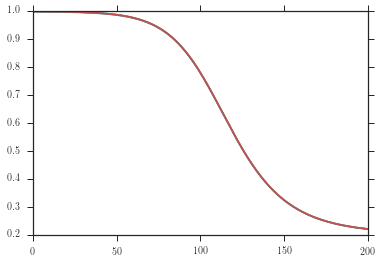

In [325]:
plt.plot(ret[:,0])
plt.plot(ret[:,1])
plt.plot(ret[:,2])